## Compiling mechanisms

Before loading the cell, the cell mechanisms need to be compiled and provided. This compilation step is a performance requirement.

Refer to the [MOD2IR: High-Performance Code Generation for a Biophysically Detailed Neuronal Simulation DSL](https://dl.acm.org/doi/abs/10.1145/3578360.3580268) publication to learn more about the compilation process.


If the mechanisms are not compiled, you need to run the `nrnivmodl` command to perform the compilation.

The mechanisms are already available at the examples directory.

With NEURON installed, simply run the following command for the compilation.


In [1]:
!nrnivmodl ../mechanisms

/home/tuncel/git-repos/BlueCelluLab/examples/singlecell
Mod files: "../mechanisms/../mechanisms/CaDynamics_DC0.mod" "../mechanisms/../mechanisms/CaDynamics_E2.mod" "../mechanisms/../mechanisms/Ca_HVA2.mod" "../mechanisms/../mechanisms/Ca_HVA.mod" "../mechanisms/../mechanisms/Ca_LVAst.mod" "../mechanisms/../mechanisms/Ca.mod" "../mechanisms/../mechanisms/DetAMPANMDA.mod" "../mechanisms/../mechanisms/DetGABAAB.mod" "../mechanisms/../mechanisms/gap.mod" "../mechanisms/../mechanisms/GluSynapse.mod" "../mechanisms/../mechanisms/Ih.mod" "../mechanisms/../mechanisms/Im.mod" "../mechanisms/../mechanisms/KdShu2007.mod" "../mechanisms/../mechanisms/K_Pst.mod" "../mechanisms/../mechanisms/K_Tst.mod" "../mechanisms/../mechanisms/Nap_Et2.mod" "../mechanisms/../mechanisms/NaTa_t.mod" "../mechanisms/../mechanisms/NaTg.mod" "../mechanisms/../mechanisms/NaTs2_t.mod" "../mechanisms/../mechanisms/netstim_inhpoisson.mod" "../mechanisms/../mechanisms/ProbAMPANMDA_EMS.mod" "../mechanisms/../mechanisms/ProbG

**Note**: The compiled mechanisms need to be provided before importing bluecellulab.

In [2]:
from pathlib import Path

from matplotlib import pyplot as plt

from bluecellulab import Cell, Simulation

	1 


## Loading the cell

A Cell is consisting of the two following components

- Electrophysiology - represented as hoc
- Morphology (shape) - represented as asc in this tutorial

In [3]:
hoc_file = Path("hoc") / "cADpyr_L2TPC.hoc"
morph_file = Path("morphology") / "rr110330_C3_idA.asc"

This command will compile the mechanisms files. The compilation step

In [4]:
morph_file

PosixPath('morphology/rr110330_C3_idA.asc')

In [5]:
from bluecellulab.circuit.circuit_access import EmodelProperties


emodel_properties = EmodelProperties(threshold_current=1.1433533430099487,
                                        holding_current=1.4146618843078613,
                                        ais_scaler=1.4561502933502197)
cell = Cell(hoc_file, morph_file, template_format="v6_ais_scaler", emodel_properties=emodel_properties)

In [6]:
cell

### Exploring cell's attributes

Morphology related attributes such as the Radius (Ra) of a section can be accessed as follows:

In [7]:
cell.soma.Ra

100.0

To see the children of a section, you can use the `children` attribute.

In [8]:
cell.soma.children()

[cADpyr_L2TPC_bluecellulab[0].apic[0],
 cADpyr_L2TPC_bluecellulab[0].dend[0],
 cADpyr_L2TPC_bluecellulab[0].axon[0]]

Properties of other sections such as length(L) can also be displayed as follows:

In [9]:
cell.apical[0].Ra

100.0

In [10]:
cell.apical[0].L

9.530376893488256

Electrophysiological attributes such as the holding and threshold currents of the cell can be accessed as follows:

In [11]:
cell.hypamp  # holding current

1.4146618843078613

In [12]:
cell.threshold

1.1433533430099487

## Simulation

In this step we will apply some stimulation to the cell and run a simulation.

Here we create a Simulation object and add the cell we wish to simulate to it.

In [13]:
sim = Simulation()
sim.add_cell(cell)

### Adding a step current

Here a step current is set to be given to the cell during the simulation.

In [14]:
cell.add_step(start_time=15.0, stop_time=25.0, level=1.0)

TStim[0]

To run the cell, we call the `run` method of the simulation object.

In [15]:
sim.run(45, cvode=False)

Retrieving the time and voltage values of the simulation is done as follows:

In [16]:
time, voltage = cell.get_time(), cell.get_soma_voltage()

**Note**: To retrieve the voltage we used `cell.get_soma_voltage()`. In the next steps we will see how to retrieve the voltage from other sections.

Text(0, 0.5, 'Voltage (mV)')

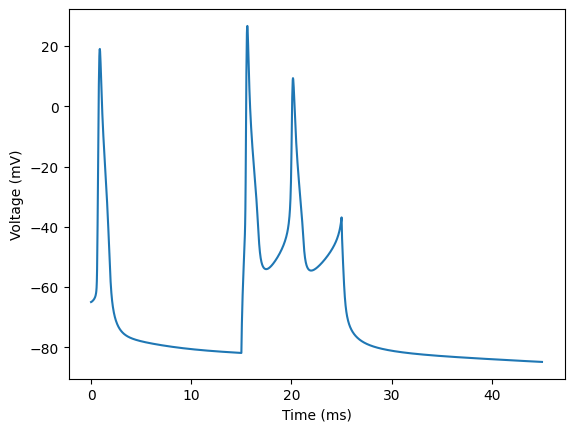

In [17]:
plt.plot(time, voltage)
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (mV)")

Here at the beginning we see a single spike and then we can clearly observe the impact of the step current we injected between 15 and 25 ms.

### Adding more complex stimulation

Besides the step current, we can also add more complex stimulation to the cell.
In this example we will add a Poisson shot noise current to the cell.

First we clear the injector before injecting another stimulus. This is important because NEURON object leaves state behind after adding a stimulus.

In [18]:
cell.clear_injector()

Here to define the ShotNoise stimulus, we need to create an object of type ShotNoise. The attributes of the stimulus object (ShotNoise object) are checked via a dynamic type checker to early detect errors and misuses.

In [45]:
from bluecellulab.stimuli import ShotNoise
from bluecellulab import RNGSettings


shotnoise_stimulus = ShotNoise(
    pattern="shot_noise", target="single-cell", delay=15, duration=20,
    rise_time=0.4, decay_time=4, rate=2E3, amp_mean=40E-3, amp_var=16E-4,
    seed=3899663
)

Since ShotNoise is a stochastic signal, we need to set the rng_settings attribute of the cell.

In [46]:
rng_obj = RNGSettings(base_seed=42)
cell.rng_settings = rng_obj

Here we add the shotnoise to the middle point (denoted by 0.5) of soma 

In [47]:
time_vec, stim_vec = cell.add_replay_shotnoise(
    cell.soma, 0.5,
    shotnoise_stimulus,
    shotnoise_stim_count=3)
time_vec = time_vec.to_python()
stim_vec = stim_vec.to_python()

Here is the current we injected to the cell.

Text(0, 0.5, 'Current (nA)')

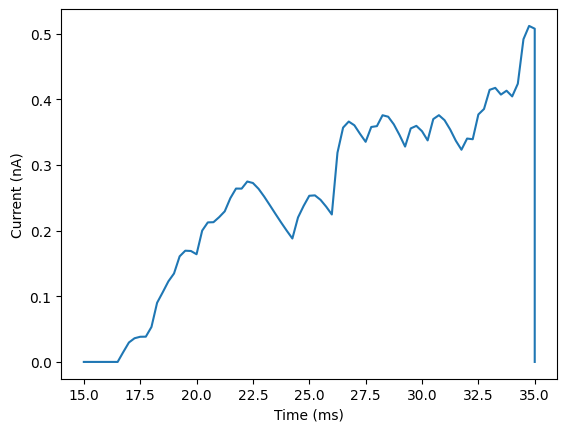

In [48]:
plt.plot(time_vec, stim_vec)
plt.xlabel("Time (ms)")
plt.ylabel("Current (nA)")

In [49]:
sim.run(45, cvode=False)
time, voltage = cell.get_time(), cell.get_soma_voltage()

The figure below shows how the cell responded to the shotnoise. 

As in the previous stimulus, there is a single spike at the beginning and the impact of shotnoise begins at 15 ms and lasts for 20ms.

Text(0, 0.5, 'Voltage (mV)')

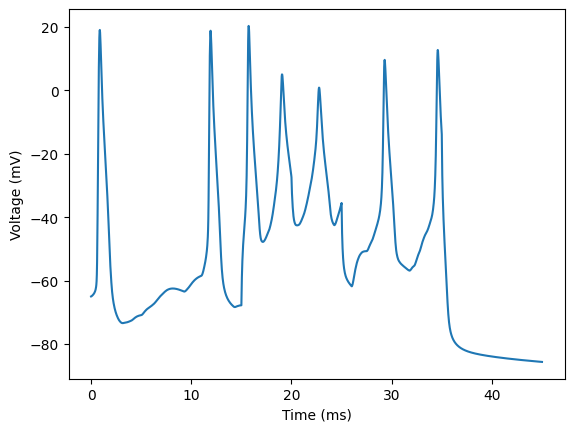

In [50]:
plt.plot(time, voltage)
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (mV)")